### https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview

In [1]:
from geopy.distance import distance
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import eli5
from sklearn.linear_model import LinearRegression, Lasso
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pandas.core.common import flatten
from sklearn import linear_model
from sklearn.svm import SVR
from math import e
import ast
from collections import Counter
from scipy.stats import pearsonr

import math
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [253]:
# read in only 10% of data due to RAM limitations
n = 100
train = pd.read_csv('/home/scott/Downloads/new-york-city-taxi-fare-prediction/train.csv', 
                    header=0, 
                    skiprows=lambda i: i % n != 0,
                   parse_dates=["pickup_datetime"])
train['dataset'] = 'train'

test = pd.read_csv('/home/scott/Downloads/new-york-city-taxi-fare-prediction/test.csv', 
                   header=0,
                  parse_dates=["pickup_datetime"])

test['dataset'] = 'test'
test['fare_amount'] = 999

#df = train.append(test)
#df.reset_index(inplace=True, drop=True)

In [254]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554238 entries, 0 to 554237
Data columns (total 9 columns):
key                  554238 non-null object
fare_amount          554238 non-null float64
pickup_datetime      554238 non-null datetime64[ns]
pickup_longitude     554238 non-null float64
pickup_latitude      554238 non-null float64
dropoff_longitude    554231 non-null float64
dropoff_latitude     554231 non-null float64
passenger_count      554238 non-null int64
dataset              554238 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 107.1 MB


In [255]:
train.memory_usage(deep=True) * 1e-6

Index                0.00
key                 46.93
fare_amount          4.43
pickup_datetime      4.43
pickup_longitude     4.43
pickup_latitude      4.43
dropoff_longitude    4.43
dropoff_latitude     4.43
passenger_count      4.43
dataset             34.36
dtype: float64

RAM will be an issue, so i have to extract info as integers from the datetime features and then drop them. Also strings (object) are super expensive so I'll have to convert them to other datatypes.

In [256]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dataset
0,2011-06-09 00:53:00.00000066,5.70,2011-06-09 00:53:00,-73.98,40.72,-73.99,40.73,3,train
1,2013-01-05 21:36:00.000000198,5.50,2013-01-05 21:36:00,-73.99,40.74,-73.98,40.74,1,train
2,2015-04-18 08:29:08.0000002,11.50,2015-04-18 08:29:08,-73.96,40.77,-73.98,40.75,1,train
3,2009-09-02 05:18:10.0000001,25.70,2009-09-02 05:18:10,-73.99,40.76,-73.86,40.77,1,train
4,2012-11-30 11:02:00.000000111,38.80,2012-11-30 11:02:00,-73.97,40.76,-73.86,40.77,1,train


# Data cleaning

In [257]:
train.dropna(inplace=True)

In [258]:
#train.pickup_datetime = pd.to_datetime(train.pickup_datetime)
#test.pickup_datetime = pd.to_datetime(test.pickup_datetime)

In [259]:
train.memory_usage(deep=True) * 1e-6

Index                4.43
key                 46.93
fare_amount          4.43
pickup_datetime      4.43
pickup_longitude     4.43
pickup_latitude      4.43
dropoff_longitude    4.43
dropoff_latitude     4.43
passenger_count      4.43
dataset             34.36
dtype: float64

Converting string to datetime freed 400 MB of RAM!

In [260]:
train.drop('key', axis=1, inplace=True)

In [261]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554231 entries, 0 to 554237
Data columns (total 8 columns):
fare_amount          554231 non-null float64
pickup_datetime      554231 non-null datetime64[ns]
pickup_longitude     554231 non-null float64
pickup_latitude      554231 non-null float64
dropoff_longitude    554231 non-null float64
dropoff_latitude     554231 non-null float64
passenger_count      554231 non-null int64
dataset              554231 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 66.6 MB


In [262]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dataset
0,5.70,2011-06-09 00:53:00,-73.98,40.72,-73.99,40.73,3,train
1,5.50,2013-01-05 21:36:00,-73.99,40.74,-73.98,40.74,1,train
2,11.50,2015-04-18 08:29:08,-73.96,40.77,-73.98,40.75,1,train
3,25.70,2009-09-02 05:18:10,-73.99,40.76,-73.86,40.77,1,train
4,38.80,2012-11-30 11:02:00,-73.97,40.76,-73.86,40.77,1,train


In [263]:
for df in [train, test]:
    df['hour'] = df.pickup_datetime.apply(lambda x: x.hour)
    df['year'] = df.pickup_datetime.apply(lambda x: x.year)
    df['weekday'] = df.pickup_datetime.apply(lambda x: x.weekday())
    df['month'] = df.pickup_datetime.apply(lambda x: x.month)
    df.drop('pickup_datetime', axis=1, inplace=True)

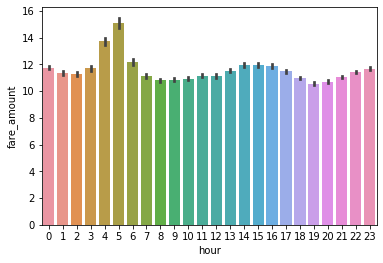

In [264]:
sns.barplot(x=train.hour, y=train.fare_amount)

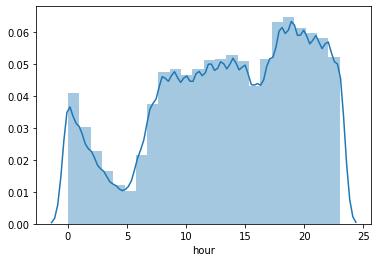

In [265]:
sns.distplot(train.hour, bins=24)

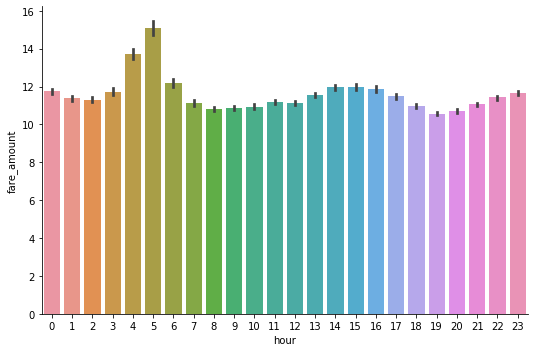

In [266]:
c = sns.catplot(x='hour', y='fare_amount', data=train, kind='bar')
c.fig.set_size_inches(8, 5)

There is a spike in mean fare amount between 4 and 6 at night. It makes sense looking at the histogram, less supply, same (or higher) demand.

<Figure size 432x288 with 0 Axes>

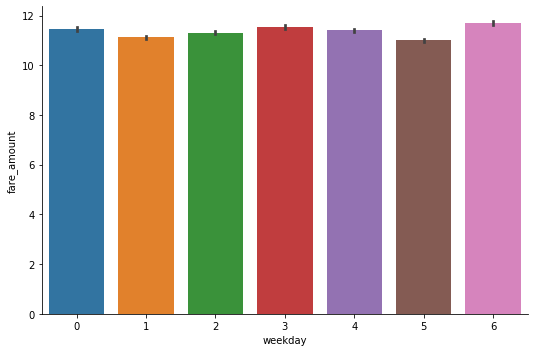

In [267]:
plt.figure()
c = sns.catplot(x='weekday', y='fare_amount', data=train, kind='bar')
c.fig.set_size_inches(8, 5)

NYC Coordinates are roughly 40.7128° N, 74.0060° W. Anything else will be considered noise.

In [268]:
train.dropoff_longitude.apply(lambda x: int(x)).value_counts()[:10]

-73    470964
-74     72189
 0      10708
 40       283
-75        19
-7         14
-1         10
-72         9
-76         3
-71         3
Name: dropoff_longitude, dtype: int64

In [269]:
train.dropoff_latitude.apply(lambda x: int(x)).value_counts()[:10]

 40    542943
 0      10675
-73       251
 41       230
 39        74
-74        32
 42         3
 4          3
 36         2
 5          1
Name: dropoff_latitude, dtype: int64

In [270]:
train.pickup_longitude.apply(lambda x: int(x)).value_counts()[:10]

-73    470208
-74     72933
 0      10708
 40       283
-75        28
-7         17
-72        10
-1          4
-76         4
-2          2
Name: pickup_longitude, dtype: int64

In [271]:
train.pickup_latitude.apply(lambda x: int(x)).value_counts()[:10]

 40    542957
 0      10670
-73       244
 41       241
 39        44
-74        39
 4          4
 42         3
 35         2
 37         2
Name: pickup_latitude, dtype: int64

In [272]:
mask1 = train.dropoff_longitude.apply(int).isin([-73, -74, -75])
mask2 = train.dropoff_latitude.apply(int).isin([40, 41])

mask3 = train.pickup_longitude.apply(int).isin([-73, -74, -75])
mask4 = train.pickup_latitude.apply(int).isin([40, 41])

train = train[(mask1 & mask2) & (mask3 & mask4) ]

In [273]:
# Much faster using linear algebra

for df in [train, test]:
    
    lat_matrix = np.column_stack((df.pickup_latitude, df.pickup_longitude))
    lon_matrix = np.column_stack((df.dropoff_latitude, df.dropoff_longitude))
    
    df['dist_manhattan'] = np.absolute(lat_matrix - lon_matrix).sum(axis=1)
    
    df['dist_euclidean'] = df.apply(lambda row: distance( (row.pickup_latitude, row.pickup_longitude), 
                                           (row.dropoff_latitude, row.dropoff_longitude)).km, 
                                            axis=1)

    #df.drop(['dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude' ], axis=1, inplace=True)

In [274]:
train.to_pickle('train_taxi_pre.pkl')
test.to_pickle('test_taxi_pre.pkl')

In [275]:
#train = pd.read_pickle('train_taxi_pre.pkl')
#test = pd.read_pickle('test_taxi_pre.pkl')

In [276]:
train = train[ (train.dist_manhattan > 0) & (train.fare_amount > 0)]

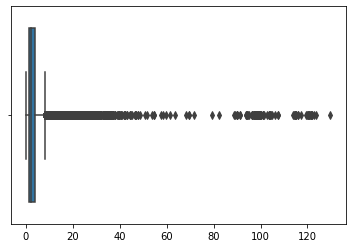

In [277]:
b = sns.boxplot(train.dist_euclidean.tolist())

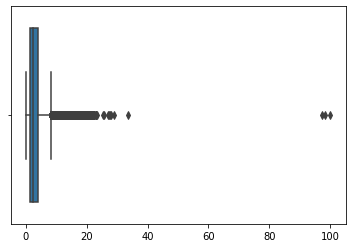

In [278]:
b = sns.boxplot(test.dist_euclidean.tolist())

We can see that an overwhelming majority of rides are very short, but we also have a lot of problematic outliers.

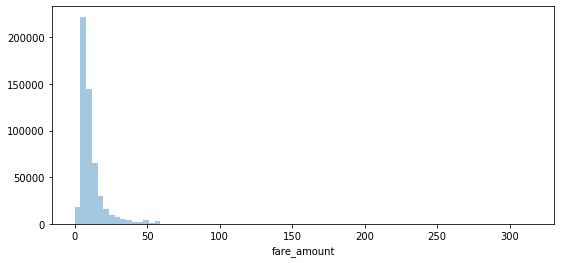

In [279]:
plt.figure(figsize=(9, 4))
sns.distplot(train.fare_amount, bins=80, kde=False)

In [280]:
train['dist_bins'] = pd.cut(train.dist_euclidean, bins=60, labels=range(60))
test['dist_bins'] = pd.cut(test.dist_euclidean, bins=60, labels=range(60))

<Figure size 432x288 with 0 Axes>

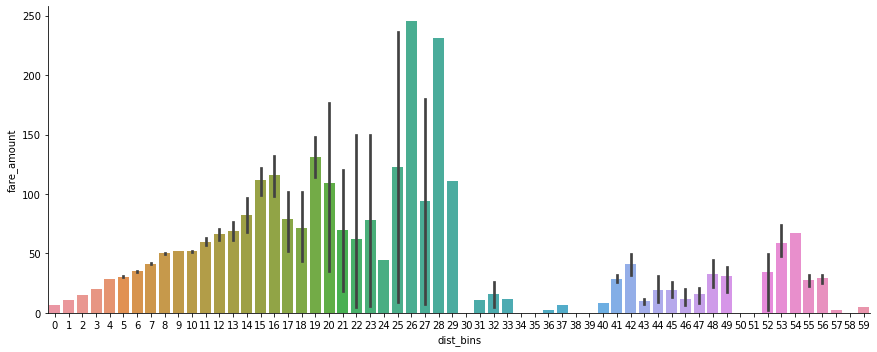

In [281]:
plt.figure()
c = sns.catplot(x='dist_bins', y='fare_amount', data=train, kind='bar')
c.fig.set_size_inches(14, 5)

We see that the dist-price relationship is perfectly linear, however, something weird happens with cohorts with long distances. You also see how the error bars are getting bigger. A linear model simply won't work if we use the data as is. The decision to make is whether we drop these outliers. I don't think we should, as they give valuable insights into those long distance rides, and there are algorithms that can handle it well (non linear ones, like decision trees or KNN).

In [282]:
train.dist_bins.value_counts().sort_index()

0     266056
1     152047
2      56307
3      23502
4      16214
5       6022
6       3939
7       2394
8       2352
9       5929
10      1377
11       186
12       109
13        39
14        24
15        23
16        21
17        11
18        10
19         9
20         5
21         5
22         3
23         2
24         1
25         2
26         1
27         2
28         1
29         1
30         0
31         1
32         2
33         1
34         0
35         0
36         1
37         1
38         0
39         0
40         1
41         5
42         2
43         6
44        10
45        27
46        10
47         4
48         4
49         3
50         0
51         0
52         3
53         8
54         1
55         7
56         5
57         1
58         0
59         1
Name: dist_bins, dtype: int64

There is a little spike around the values 44-46 which doesn't look random. However, given how few values these are, I don't think it's wise to invest time in investigating it at this moment.

In [283]:
test.dist_bins.value_counts().sort_index()

0     3570
1     3159
2     1352
3      686
4      355
5      279
6      139
7       75
8       53
9       36
10      36
11      48
12      96
13      18
14       1
15       2
16       4
17       1
18       0
19       0
20       1
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       2
59       1
Name: dist_bins, dtype: int64

Dropping the outlier values.

In [284]:
train.corr()['fare_amount']

fare_amount          1.00
pickup_longitude     0.40
pickup_latitude     -0.20
dropoff_longitude    0.30
dropoff_latitude    -0.16
passenger_count      0.02
hour                -0.02
year                 0.12
weekday              0.00
month                0.02
dist_manhattan       0.82
dist_euclidean       0.82
Name: fare_amount, dtype: float64

In [285]:
train.corr()['fare_amount']

fare_amount          1.00
pickup_longitude     0.40
pickup_latitude     -0.20
dropoff_longitude    0.30
dropoff_latitude    -0.16
passenger_count      0.02
hour                -0.02
year                 0.12
weekday              0.00
month                0.02
dist_manhattan       0.82
dist_euclidean       0.82
Name: fare_amount, dtype: float64

<Figure size 432x288 with 0 Axes>

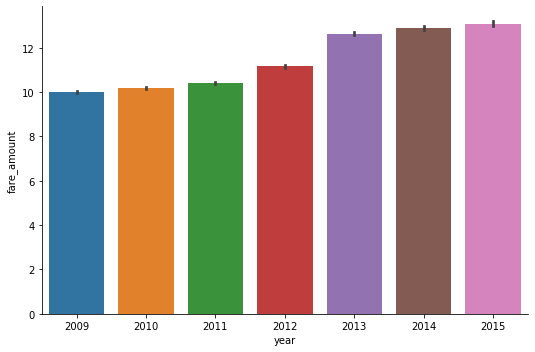

In [286]:
plt.figure()
c = sns.catplot(x='year', y='fare_amount', data=train, kind='bar')
c.fig.set_size_inches(8, 5)

As expected, the fare rises over time due to inflation and rising prices

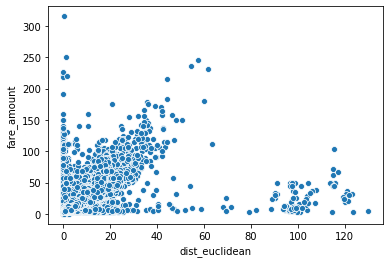

In [287]:
sns.scatterplot(train.dist_euclidean, train.fare_amount)

In [288]:
# Looking at these rows, the fare was high but the car hardly covered any distance.
# Knowing there is a standing fee (30$ per hour), it means the passenger would
# need to be stuck in traffic almost 7-8 hours, which is not reasonable.

In [289]:
train.sort_values('fare_amount', ascending=False)[['fare_amount', 'dist_euclidean']].head(20)

,fare_amount,dist_euclidean
217602,315.00,0.28
74585,250.00,1.12
427192,245.54,57.52
17290,236.25,54.63
271117,231.00,61.53
202475,225.85,0.00
150503,222.30,0.00
499615,220.00,1.70
153968,218.00,0.00
467941,215.20,44.37


In [290]:
# Dropping the rows where the distance was less than 2km and the passenger
# presumably spent more than 2 hours in a cab

train = train[~ ( (train.dist_euclidean < 2) & (train.fare_amount > 80) ) ]

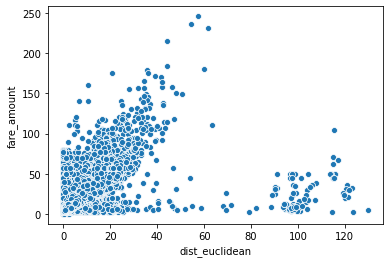

In [291]:
sns.scatterplot(train.dist_euclidean, train.fare_amount)

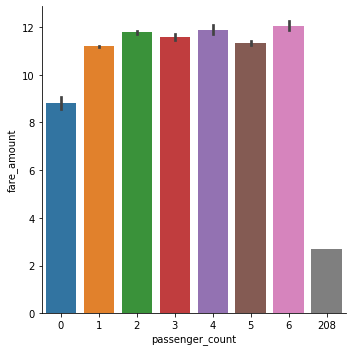

In [292]:
sns.catplot(x='passenger_count', y='fare_amount', data=train , kind='bar')

In [293]:
train[train.passenger_count == 208]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dataset,hour,year,weekday,month,dist_manhattan,dist_euclidean,dist_bins
520035,2.70,-73.94,40.76,-73.94,40.76,208,train,21,2009,0,3,0.00,0.00,0


In [294]:
train = train[train.passenger_count < 7]

In [295]:
train.to_pickle('train_taxi.pkl')
test.to_pickle('test_taxi.pkl')

In [2]:
train = pd.read_pickle('train_taxi.pkl')
test = pd.read_pickle('test_taxi.pkl')

In [201]:
# The biggest problem with this dataset is that there is not dropoff time.

# Model selection

This dataset is highly linear (distance - fare) so linear models should perform quite well.

In [3]:

train.drop(['dataset', 'dist_bins', 'dist_manhattan'], axis=1, inplace=True)

In [4]:
y = train.fare_amount
train.drop('fare_amount', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=0)


# In the interest of preventing information about the distribution of the test set 
# leaking into your model, you should go for option #2 and fit the scaler on your 
# training data only, then standardise both training and test sets with that scaler. 
# By fitting the scaler on the full dataset prior to splitting (option #1), information 
# about the test set is used to transform the training set, which in turn is passed downstream.

# https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data

In [5]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(np.array(X_train))
X_test = sc_X.transform(np.array(X_test))

### KNN

In [7]:
knn = KNeighborsRegressor()

param_grid = {'n_neighbors': np.arange(1, 25), 
              'weights': ['uniform', 'distance'], # give more voting power to points that are closer
             'p' : [1, 2]} # euclidean vs manhattan

# Randomsearch, by convention, always tries to maximize its score so loss functions like MSE have to be negated
knn_gscv = RandomizedSearchCV(knn, param_grid, cv=3,scoring='neg_mean_squared_error', n_jobs=-1)
knn_gscv.fit(X_train, y_train)
knn_gscv.best_params_

{'weights': 'distance', 'p': 1, 'n_neighbors': 15}

In [8]:

best_knn = KNeighborsRegressor(n_neighbors=knn_gscv.best_params_['n_neighbors'], 
                               weights=knn_gscv.best_params_['weights'],
                              p =knn_gscv.best_params_['p'])
'''

best_knn = KNeighborsRegressor(n_neighbors=18, 
                               weights='uniform',
                              p =1, algorithm='kd_tree')
'''
best_knn.fit(X_train, y_train)

pred = best_knn.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

In [9]:
test_errors = {'knn' : error}

# Decision Trees

In [10]:
leaf_size = np.linspace(0.001, 0.1, 10, endpoint=True)

In [11]:
tree = DecisionTreeRegressor()

param_grid = {'max_depth': [int(x) for x in np.linspace(1, 100, num=15)],
             'min_samples_leaf' : leaf_size}

tree_gscv = RandomizedSearchCV(tree, param_grid, cv=3,scoring='neg_mean_squared_error', n_jobs=-1)
tree_gscv.fit(X_train, y_train)
tree_gscv.best_params_

{'min_samples_leaf': 0.001, 'max_depth': 50}

In [12]:
# A leaf is a node that won't be split further.
# The default value for min_samples_leaf is 1, which would lead to overfitting.


best_tree = DecisionTreeRegressor(min_samples_leaf= tree_gscv.best_params_['min_samples_leaf'], 
                                  max_depth= tree_gscv.best_params_['max_depth'] )
'''


best_tree = DecisionTreeRegressor(min_samples_leaf= 0.012, 
                                  max_depth= 57)
'''
                                 
best_tree.fit(X_train, y_train)
pred = best_tree.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

In [13]:
test_errors['tree'] = error

# Random Forest

They're an example of BAGGING, where a lot of weak models are combined to create a strong model. Those models are not dependent on each other (paralell). Random forests build many trees, and use a majority vote (or a mean of vote) to predict the dependent variable. When building each tree, a random set of rows and features is selected. This makes this model very robust to overfitting.

<b>I could not run this model as I have not enough RAM and the kernel crashes.<br>
It's performance should be, however, on par with AdaBoost (or slightly worse)

In [ ]:
forest = RandomForestRegressor(n_jobs=-1)

param_grid = {'n_estimators': [int(x) for x in np.linspace(3, 300, num=15) ], }

forest_gscv = RandomizedSearchCV(forest, param_grid, cv=3,scoring='neg_mean_squared_error', n_jobs=-1)
forest_gscv.fit(X_train, y_train)
forest_gscv.best_params_

In [ ]:
#best_forest = RandomForestRegressor(n_estimators = forest_gscv.best_params_['n_estimators'])
best_forest = RandomForestRegressor(n_estimators = 300)
best_forest.fit(X_train, y_train)
pred = best_forest.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

test_errors['forest'] = error

In [ ]:
test_errors

# Lasso Regression

In [14]:
params = {'alpha' : np.linspace(0.1, 500000, num=1000)}

lasso = linear_model.Lasso()
lasso_grid = RandomizedSearchCV(lasso, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

lasso_grid.fit(X_train, y_train);

In [15]:
best_lasso = linear_model.Lasso(alpha=lasso_grid.best_params_['alpha'])

best_lasso.fit(X_train, y_train)
pred = best_lasso.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

In [16]:
test_errors['lasso'] = error

# Ridge Regression

In [17]:
from sklearn.linear_model import Ridge
params = {'alpha' : np.linspace(0.1, 500000, num=1000)}

ridge = linear_model.Ridge()
ridge_grid = RandomizedSearchCV(ridge, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

ridge_grid.fit(X_train, y_train);

In [18]:
best_ridge = linear_model.Ridge(alpha=ridge_grid.best_params_['alpha'])

best_ridge.fit(X_train, y_train)
pred = best_ridge.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

In [19]:
test_errors['ridge'] = error

### Adaboost

Boosting involves creating many weak models, that are dependent on each other (unlike bagging). For every model, the weights are increased on the data points where the previous model got the answers wrong. At the end, every model gets its own importance weight, depending on its accuracy. Then the voting happens.

With pipeline to prevent data leakage:

In [ ]:
from sklearn.pipeline import Pipeline

ada_pipe = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("adaboost", AdaBoostRegressor()),
    ))

ada = AdaBoostRegressor(base_estimator=ada_pipe, random_state=0)

params = {'n_estimators': range(2, 100)}
ada_grid = RandomizedSearchCV(ada, params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
ada_grid.fit(X_train, y_train);
ada_grid.best_params_['n_estimators']

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Without pipeline (much faster):

In [20]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                              random_state=0)
params = {'n_estimators': range(2, 100)}
ada_grid = RandomizedSearchCV(ada, params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
ada_grid.fit(X_train, y_train);
ada_grid.best_params_['n_estimators']


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


87

In [21]:

best_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                              random_state=0, 
                             n_estimators=ada_grid.best_params_['n_estimators'])
'''

best_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                              random_state=0, 
                             n_estimators=87)
'''
best_ada.fit(X_train, y_train)
pred = best_ada.predict(X_test)
error = math.sqrt(mean_squared_error(y_test,pred))

In [22]:
test_errors['ada'] = error

## Model leaderboard

In [24]:
pd.Series(test_errors).sort_values()

ada     3.42
knn     3.68
tree    3.80
ridge   5.02
lasso   9.41
dtype: float64

In [25]:
eli5.show_weights(best_ada, feature_names=list(train.columns))

Weight,Feature
0.6351 ± 0.0863,dist_euclidean
0.1125 ± 0.0609,dropoff_longitude
0.0803 ± 0.0810,dropoff_latitude
0.0486 ± 0.0314,pickup_longitude
0.0355 ± 0.0230,year
0.0348 ± 0.0137,pickup_latitude
0.0212 ± 0.0175,hour
0.0147 ± 0.0067,month
0.0114 ± 0.0198,weekday
0.0058 ± 0.0060,passenger_count


In [28]:
key = test.key

test = test[ ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'year', 'weekday',
       'month', 'dist_euclidean']]

In [29]:
X_test = sc_X.transform(np.array(test))

In [30]:
FINAL = pd.DataFrame()
FINAL['key'] = key
FINAL['fare_amount'] = list(best_ada.predict(X_test))
FINAL.reset_index(inplace=True, drop=True)

In [31]:
FINAL.to_csv('nyc_submission.csv', index=False)

My score was 3.50906 which puts me in top 45% of participants, which is slightly better than average.